In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\oscar.azrak\Desktop\Master-thesis\Master-thesis\Files\func.py:21: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 9

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models

NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))


c:\appl\Anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.1.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\appl\Anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator RidgeClassifier from version 1.4.1.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\appl\Anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. F

In [7]:

# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Ridge Classifier:
Accuracy: 0.5281781630148452
Confusion Matrix:
[[70783 28420]
 [63464 32076]]
Precision: 0.5302168738428987
Recall: 0.33573372409462005
F1 Score: 0.411135891717296
MSE: 0.4718218369851548
RMSE: 0.6868928861075465


XGBoost Classifier:
Accuracy: 0.5266325362143954
Confusion Matrix:
[[58120 41083]
 [51102 44438]]
Precision: 0.5196150653055974
Recall: 0.46512455516014234
F1 Score: 0.490862195613633
MSE: 0.4733674637856046
RMSE: 0.6880170519584559


LightGBM Classifier:
Accuracy: 0.5251279891960173
Confusion Matrix:
[[59317 39886]
 [52592 42948]]
Precision: 0.5184827486297897
Recall: 0.4495289930918987
F1 Score: 0.48155000168185946
MSE: 0.47487201080398267
RMSE: 0.6891095782268468




In [128]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [129]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy()
}


In [130]:
def update_df_with_asset_performance(df, portfolios, value, hold_days=10):
    """ Update df by marking assets in portfolios with a specified value starting two days after for a duration. """
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value


# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {} }
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {} }

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 1)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], -1)




[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [135]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read


In [137]:
%reload_ext autoreload
%autoreload 2


In [150]:
def calculate_trade_volume(df):
    # Calculate the change in position for each column
    position_changes = df.diff().fillna(0)  # Using fillna(0) to handle the first row if necessary
    
    # Count the number of trades: transitions from 0 to 1/-1 or 1/-1 to 0
    # Abs(position_changes) == 1 will return True for these transitions
    trades = (position_changes.abs() == 1)
    
    # Sum up the trades for each day to get the volume of trades
    trade_volume_per_day = trades.sum(axis=1)
    
    return trade_volume_per_day

xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)



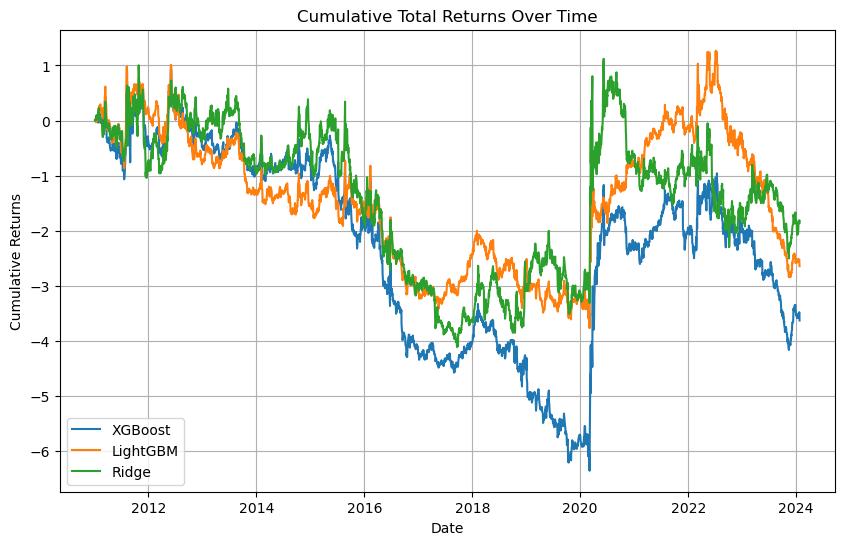

In [151]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = xgb_total_returns.cumsum()
lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [157]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum()/12)
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum()/12)
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")

XGBoost trade volume:
966.8333333333334


LightGBM trade volume:
918.6666666666666


Ridge trade volume:
11509




In [156]:
ridge_weights.head(16)

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-10,0,0,-1,1,1,0,-1,0,0,-1,0,0,0,-1,0,0,-1,1,1,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-11,0,0,-1,1,1,0,-1,0,0,-1,0,0,0,-1,0,0,-1,1,1,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-12,0,0,-1,1,1,1,-1,0,-1,-1,0,0,0,-1,0,0,-1,1,1,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-13,0,0,-1,1,1,1,-1,0,-1,-1,0,0,0,-1,1,0,-1,1,1,0,0,0,-1,0,1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,-1,0,0,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0
2011-01-14,0,0,-1,1,1,1,-1,0,-1,-1,1,0,0,-1,1,0,-1,1,1,0,0,0,-1,0,1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,-1,0,0,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0
2011-01-17,1,0,-1,1,1,1,-1,0,-1,-1,1,1,1,-1,1,0,-1,1,1,0,0,0,-1,0,1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,-1,0,0,0,0,-1,0,0,0,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0
